---
title: SpatioTemporal Field - T2M - Stationary
subject: AEMET T2M
short_title: 1 - EDA
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CSIC
      - UCM
      - IGEO
    orcid: 0000-0002-6739-0053
    email: juanjohn@ucm.es
license: CC-BY-4.0
keywords: notation
---

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform("cpu")

In [2]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray

from st_evt.viz import plot_spain, plot_scatter_ts, plot_histogram, plot_density

from omegaconf import OmegaConf
from st_evt import CANDIDATE_STATIONS
from st_evt.utils import ExperimentPath

from loguru import logger

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)



# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Paths

In [3]:
import os
from pathlib import Path

logger.info("Initializaing paths...")

data_dir = Path(os.getenv("DATA_DIR"))
raw_data_dir = Path(os.getenv("RAW_DATA_SAVEDIR"))
clean_data_dir = Path(os.getenv("CLEAN_DATA_SAVEDIR"))
exp_data_dir = Path(os.getenv("EXPERIMENT_SAVEDIR"))

2025-01-10 06:41:34.702 | INFO     | __main__:<module>:4 - Initializaing paths...


## Experiment

#### Configuration

In [14]:
config = dict(
    # EXPERIMENT
    experiment_name="walkthrough/ts_t2m_spain/stationary_iid",
    # EXPERIMENT PARAMS
    dataset="aemet",
    station_id="spain-redfeten",
    variable="t2m",
    likelihood="gevd",
    freq="summer",
    dependence="temporal",
    parameterization="linear",
    # CONFIGURATION PARAMS
    config_file_name="aemet_spain_stationary.yaml",
    # DATASETS
    covariate_path=str(data_dir.joinpath("clean/gmst/gmst_david.zarr")),
    dataset_path=str(data_dir.joinpath("clean/aemet/t2max_stations.zarr")),
)
config

{'experiment_name': 'walkthrough/ts_t2m_spain/stationary_iid',
 'dataset': 'aemet',
 'station_id': 'spain-redfeten',
 'variable': 't2m',
 'likelihood': 'gevd',
 'freq': 'summer',
 'dependence': 'temporal',
 'parameterization': 'linear',
 'config_file_name': 'aemet_spain_stationary.yaml',
 'covariate_path': '/home/juanjohn/projects/st_evt/data/clean/gmst/gmst_david.zarr',
 'dataset_path': '/home/juanjohn/projects/st_evt/data/clean/aemet/t2max_stations.zarr'}

#### Paths

In [15]:
# initialize filepath
root_dir = exp_data_dir.joinpath(config["experiment_name"])
exp_file_config = ExperimentPath(root_dir=root_dir)
config["exp_path"] = str(exp_file_config.exp_dir)

# extract relevant paths
figures_path = exp_file_config.figures_eda_dir
logger.debug(f"Figures Save Path: {figures_path}")
config["figures_path"] = str(figures_path)

data_path = exp_file_config.data_dir
logger.debug(f"Data Save Path: {data_path}")
config["data_path"] = str(data_path)

2025-01-10 06:43:16.010 | DEBUG    | __main__:<module>:8 - Figures Save Path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/figures/eda
2025-01-10 06:43:16.011 | DEBUG    | __main__:<module>:12 - Data Save Path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data


In [16]:
config_file_name = str(exp_file_config.config_dir.joinpath("config.json"))
logger.debug(f"Save Filename: {config_file_name}")
OmegaConf.save(config, config_file_name)

logger.info(f"Loading file...")
logger.debug(f"Load Filename: {config_file_name}")
config = OmegaConf.load(config_file_name)
config

2025-01-10 06:43:16.317 | DEBUG    | __main__:<module>:2 - Save Filename: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/config/config.json
2025-01-10 06:43:16.321 | INFO     | __main__:<module>:5 - Loading file...
2025-01-10 06:43:16.321 | DEBUG    | __main__:<module>:6 - Load Filename: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/config/config.json


{'experiment_name': 'walkthrough/ts_t2m_spain/stationary_iid', 'dataset': 'aemet', 'station_id': 'spain-redfeten', 'variable': 't2m', 'likelihood': 'gevd', 'freq': 'summer', 'dependence': 'temporal', 'parameterization': 'linear', 'config_file_name': 'aemet_spain_stationary.yaml', 'covariate_path': '/home/juanjohn/projects/st_evt/data/clean/gmst/gmst_david.zarr', 'dataset_path': '/home/juanjohn/projects/st_evt/data/clean/aemet/t2max_stations.zarr', 'exp_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid', 'figures_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/figures/eda', 'data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data'}

## Load Data

In [17]:
from st_evt.extremes import block_maxima_year

### Data

In [20]:
# LOAD DATA
data_url = config["dataset_path"]
ds = xr.open_dataset(data_url, engine="zarr")
ds = ds.transpose("time", "station_id")

# VARIABLES
variable = "t2max"
variable_bm = "t2m_max_bm_year"
covariate = "gmst"

# SELECT CANDIDATE STATION
ds = ds.where(ds.red_feten_mask == 1, drop=True)

# SELECT SPECIFIC MONTHS
autumn_months = [6, 7, 8]
ds = ds.sel(time=ds['time'].dt.month.isin(autumn_months))

# CALCULATE BLOCK MAXIMUM
ds[variable_bm] = block_maxima_year(ds[variable])

# calculate thresholds (for later)
quantiles = [0.90, 0.95, 0.98, 0.99, 0.995]
ds["threshold"] = ds[variable].quantile(q=quantiles)

# RESAMPLE (to remove NANS)
ds_bm = ds[[variable_bm]].resample(time="1YE").max()

# ADD COVARIATE
ds_gmst = xr.open_dataset(config["covariate_path"], engine="zarr").load()
ds_gmst = ds_gmst.interp_like(ds_bm)
ds_bm[covariate] = ds_gmst.GISS_smooth

# REMOVE NANS
ds_bm = ds_bm.dropna(dim="time")

# ADD THRESHDOLD
ds_bm["threshold"] = ds["threshold"]

# TICKERY
ds_bm = ds_bm.swap_dims({"time": "gmst"})
ds_bm["gmst"].attrs["long_name"] = "Global Mean Surface Temperature Anomaly"
ds_bm["gmst"].attrs["short_name"] = "Global Mean Surface Temperature"
ds_bm["gmst"].attrs["units"] = "[°C]"

ds_bm

<xarray.Dataset> Size: 74kB
Dimensions:          (gmst: 60, station_id: 154, quantile: 5)
Coordinates:
    alt              (station_id) float32 616B 32.0 118.0 71.0 ... 620.0 10.0
    lat              (station_id) float32 616B 40.96 41.15 41.19 ... 28.49 28.13
    lon              (station_id) float32 616B 0.87 1.108 ... -16.32 -15.42
    red_feten_mask   (station_id) uint8 154B 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * station_id       (station_id) <U5 3kB '0002I' '0016B' ... 'C447B' 'C659T'
    station_name     (station_id) <U50 31kB 'vandellòs' ... 'las palmas de g....
    time             (gmst) datetime64[ns] 480B 1961-12-31 ... 2020-12-31
  * gmst             (gmst) float64 480B 0.1988 0.1827 0.1587 ... 1.133 1.196
  * quantile         (quantile) float64 40B 0.9 0.95 0.98 0.99 0.995
Data variables:
    t2m_max_bm_year  (gmst, station_id) float32 37kB 32.2 33.32 ... 40.31 28.28
    threshold        (quantile) float64 40B 35.1 36.7 38.4 39.48 40.37

## Visualization

### Maps - Mean Statistics

In [21]:
import matplotlib.colors as colors

# colormap
cmap = plt.get_cmap('Reds', 6)
vmin = 20.0
vmax = 50.0
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# labels
cbar_label = "2m Max Temperature [°C]"

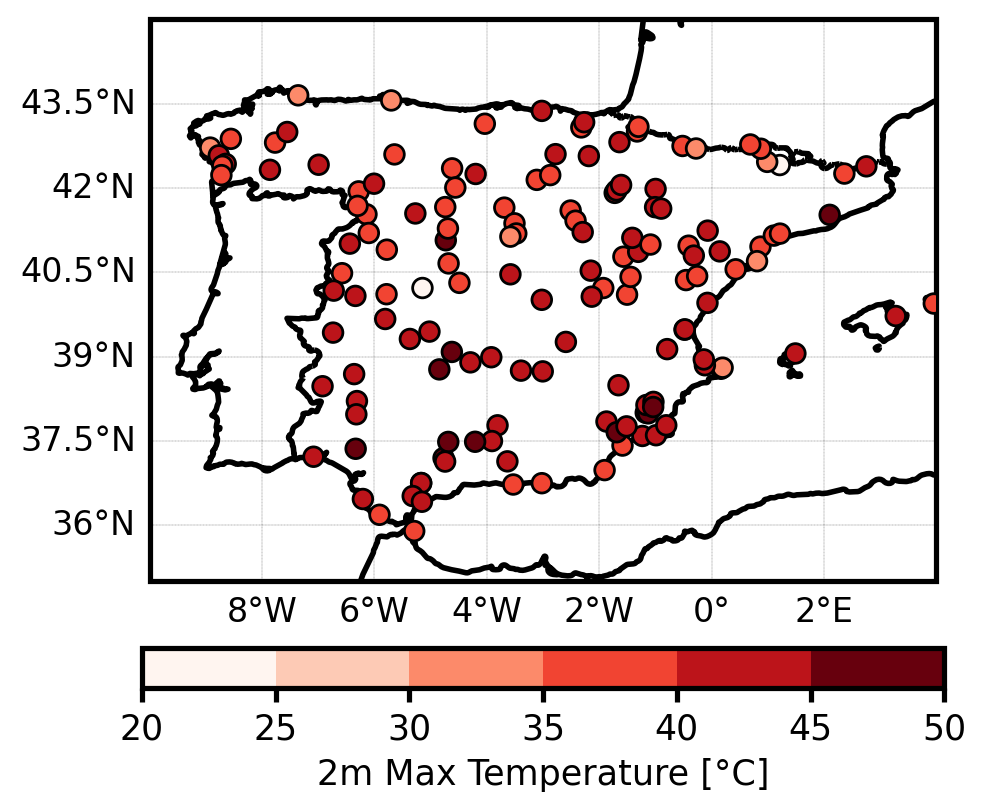

In [22]:
# plot field (with helper function)
fig, ax, cbar = plot_spain(
    ds_bm[variable_bm].max(dim="gmst"), 
    cmap=cmap, norm=norm,
    s=50.0, 
    edgecolors="black", linewidths=1.0, region="mainland", 
    vmin=vmin, vmax=vmax
)

cbar.set_label("2m Max Temperature [°C]")
# # plot geometry
# gdf_vlc.boundary.plot(ax=ax, edgecolor="black", linewidth=2, linestyle="-")

# # fix ticks
# cbar.set_label(cbar_label)
# cbar.set_ticks([1, 10, 100, 1000])
# cbar.set_ticklabels(['1', '10', '100', "1000"])

plt.tight_layout()
fig.set(
    dpi=100,
    size_inches=(10,4)
)
fig.savefig(figures_path.joinpath("map_spain_timemax.png"))
plt.show()

### Data

#### Scatter

In [23]:
# fig, ax, pts = plot_scatter_station(ds[variable].squeeze())
# fig.set_size_inches(6, 4)
# plt.tight_layout()
# fig.savefig(figures_path.joinpath("ts_data.png"))
# plt.show()

In [24]:
ds[variable].squeeze()

<xarray.DataArray 't2max' (time: 5704, station_id: 154)> Size: 4MB
array([[23.6     , 24.758974, 24.217667, ..., 22.4     , 18.71507 ,
        23.071266],
       [23.6     , 24.739342, 24.197628, ..., 21.7     , 18.661848,
        20.342537],
       [22.2     , 23.321556, 22.579473, ..., 23.2     , 18.613628,
        22.316505],
       ...,
       [30.      , 30.4     , 29.8     , ..., 21.1     , 22.6     ,
        23.867367],
       [30.7     , 31.1     , 30.622557, ..., 28.4     , 24.2     ,
        23.6     ],
       [30.      , 31.1     , 30.      , ..., 26.      , 24.9     ,
        23.5     ]], dtype=float32)
Coordinates:
    alt             (station_id) float32 616B 32.0 118.0 71.0 ... 620.0 10.0
    lat             (station_id) float32 616B 40.96 41.15 41.19 ... 28.49 28.13
    lon             (station_id) float32 616B 0.87 1.108 1.217 ... -16.32 -15.42
    red_feten_mask  (station_id) uint8 154B 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * station_id      (station_id) <U5 3kB '0002I' '0016B' ... 'C447B' 'C659T'
    station_name    (station_id) <U50 31kB 'vandellòs' ... 'las palmas de g.c...
  * time            (time) datetime64[ns] 46kB 1961-06-01 ... 2022-08-31
Attributes:
    long_name:      2m Temperature Max
    standard_name:  2m_temperature_max
    units:          degree_Celsius

In [25]:
# fig, ax, pts = plot_scatter_ts(ds[variable].squeeze(), )
# fig.set(
#     dpi=100,
#     size_inches=(7,4)
# )
# plt.tight_layout()
# fig.savefig(figures_path.joinpath("ts_data.png"))
# plt.show()

#### Histogram

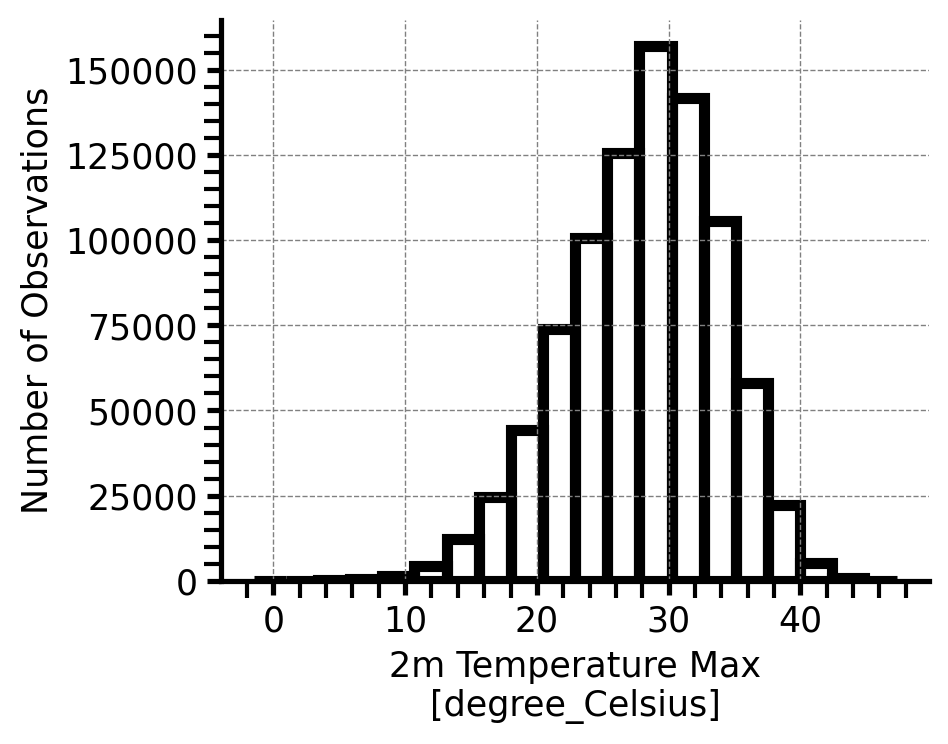

In [26]:
fig, ax = plot_histogram(ds[variable])
ax.set(
    title=""
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("hist_data.png"))
plt.show()

#### Density

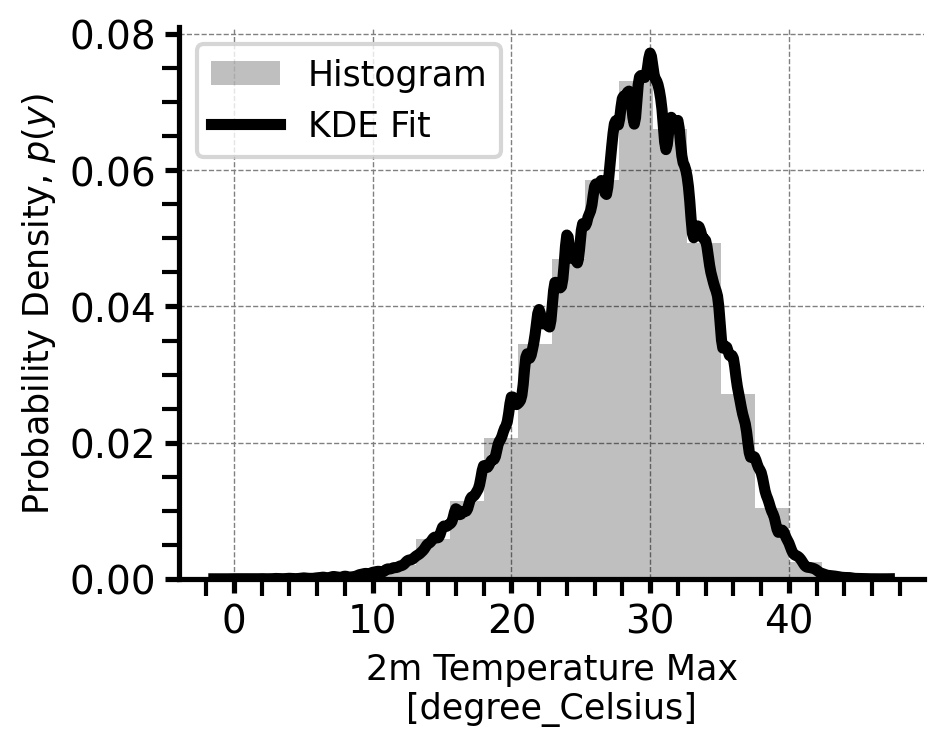

In [27]:
fig, ax = plot_density(ds[variable])
ax.set(
    title=""
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("density_data.png"))
plt.show()

### Block Maxima

#### Histogram

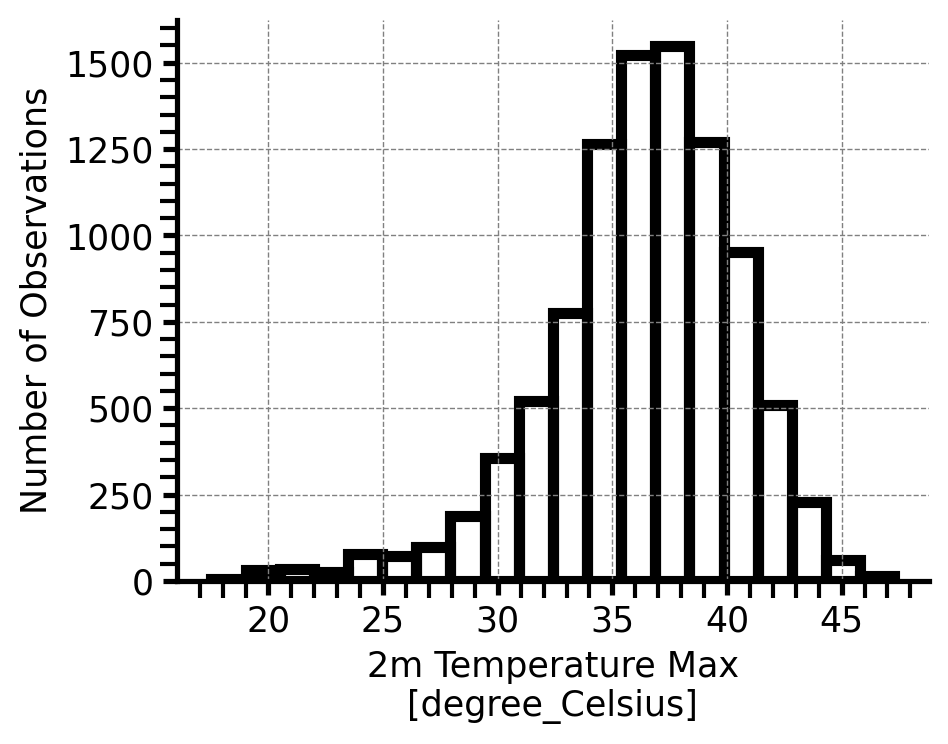

In [28]:
fig, ax = plot_histogram(ds[variable_bm])
ax.set(
    title=""
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("hist_bm.png"))
plt.show()

#### Density

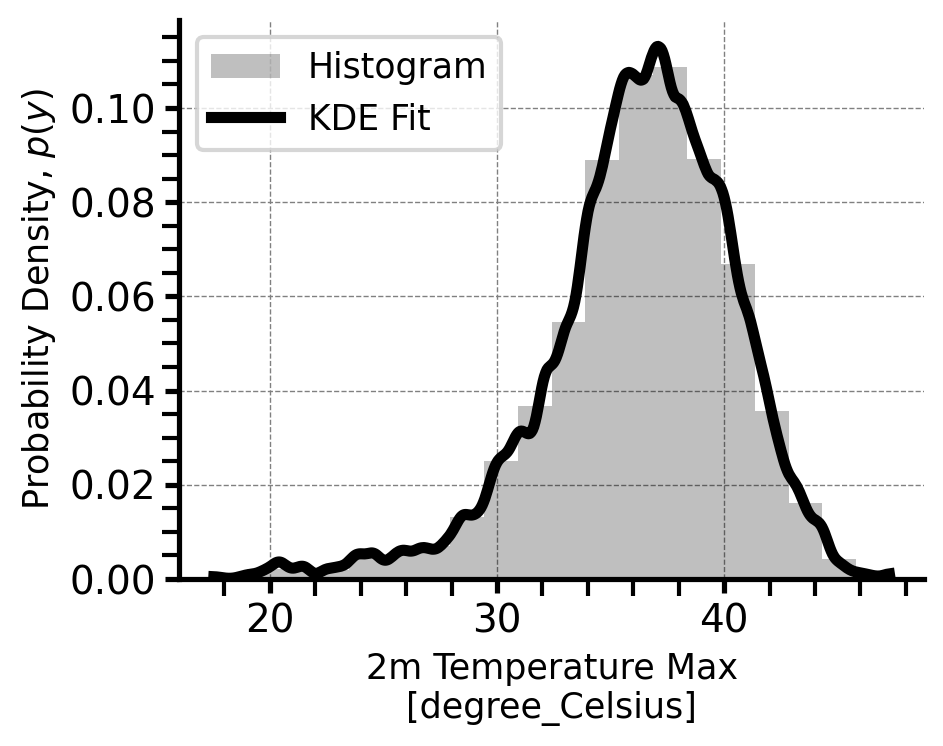

In [29]:
fig, ax = plot_density(ds[variable_bm])
ax.set(
    title=""
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("density_bm.png"))
plt.show()

### Save To Folder

In [30]:
clean_data_path = data_path.joinpath("clean_data.nc")
ds_bm.to_netcdf(clean_data_path)

In [31]:
config["clean_data_path"] = str(clean_data_path)

OmegaConf.save(config, config_file_name)

In [32]:
!ls $figures_path

density_bm.png	  hist_bm.png	 map_spain_timemax.png
density_data.png  hist_data.png


In [33]:
!cat $config_file_name

experiment_name: walkthrough/ts_t2m_spain/stationary_iid
dataset: aemet
station_id: spain-redfeten
variable: t2m
likelihood: gevd
freq: summer
dependence: temporal
parameterization: linear
config_file_name: aemet_spain_stationary.yaml
covariate_path: /home/juanjohn/projects/st_evt/data/clean/gmst/gmst_david.zarr
dataset_path: /home/juanjohn/projects/st_evt/data/clean/aemet/t2max_stations.zarr
exp_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid
figures_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/figures/eda
data_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data
clean_data_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data/clean_data.nc


In [34]:
logger.debug(config_file_name)

2025-01-10 06:43:39.663 | DEBUG    | __main__:<module>:1 - /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/config/config.json
